## ICA 1

1. Train and display a decision tree with `max_depth=3` which classifies the `species` of a penguin via the four features shown below in the `sns.pairplot()`
1. Classify the following penguin by manually following their path through the tree:
    - body_mass_g = 4000
    - flipper_length_mm = 200
    - bill_depth_mm = 17
    - bill_length_mm = 45
1. Build a confusion matrix which shows how this decision tree performs in classifying "new" samples (cross validate).
1. Repeat part 1 of this ICA but set `max_depth=None` so that the tree continues building nodes until leaf nodes contain only a single class of samples (i.e. Gini score of each leaf is 0).  Critique this decision tree, is it appropriate to use on some new, unseen sample?
        


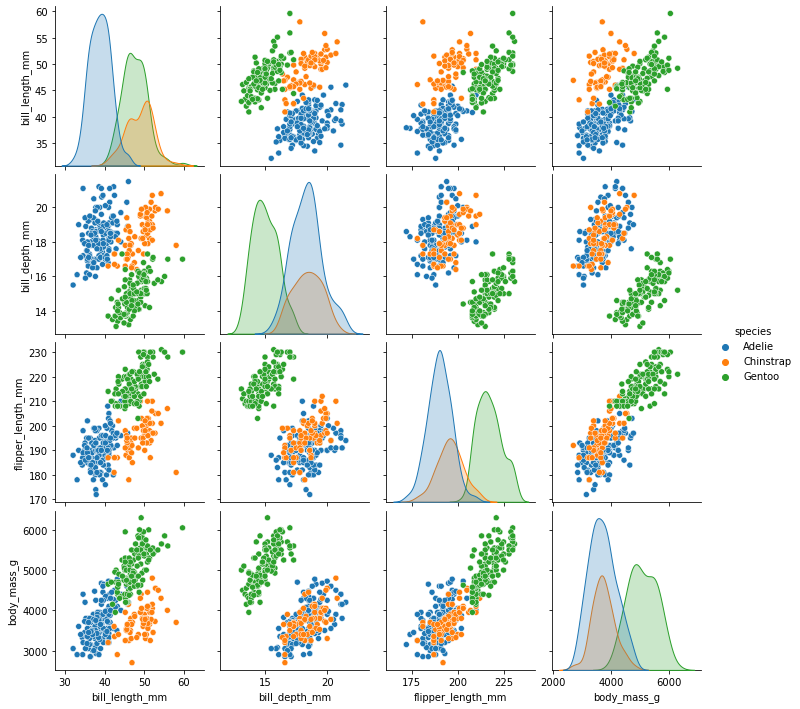

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

df_penguin = sns.load_dataset('penguins')

df_penguin.dropna(axis=0, inplace=True)

sns.pairplot(df_penguin, hue='species')

- body_mass_g = 4000
- flipper_length_mm = 200
- bill_depth_mm = 17
- bill_length_mm = 45

----------------------

- since flipper_length_mm <= 206.5 (yes) we move left
- since bill_length_mm > 43.35     (no)  we move right
- since body_mass_g <= 4125        (yes) we move left

we estimate as the second species (chinstrap):

In [2]:
# train & decision tree
from sklearn import tree
def train_dec_tree_penguin(df_penguin, max_depth=3, x_feat_list=None, plot=True):
    """ trains a decision tree classifier, optionally prints graph
    
    Args:
        df_penguin (pd.DataFrame): penguins
        max_depth (int): max depth of decision tree
        x_feat_list (list): list of input features
        plot (bool): toggles graph output (default: True)
        
    Returns:
        dec_tree_clf (DecisionTreeClassifier): trained
            decicision tree
    """
    
    if x_feat_list is None:
        # default x_feat_list
        x_feat_list = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
    # extract data from dataframe
    x = df_penguin.loc[:, x_feat_list].values
    y = df_penguin.loc[:, 'species'].values
    
    # build decision tree classifier
    dec_tree_clf = tree.DecisionTreeClassifier(max_depth=max_depth)

    # fit data
    dec_tree_clf.fit(x, y)
    
    # plot figure of decision tree
    if plot:
        # initialize empty figure (plot_tree sets text size to fill given figure
        # if we resize figure afterwards text size remains too small)
        plt.figure()
        plt.gcf().set_size_inches(20, 15)
        
        # 'plot' decision tree
        tree.plot_tree(dec_tree_clf, 
                       feature_names=x_feat_list, class_names=dec_tree_clf.classes_);
    
    return dec_tree_clf

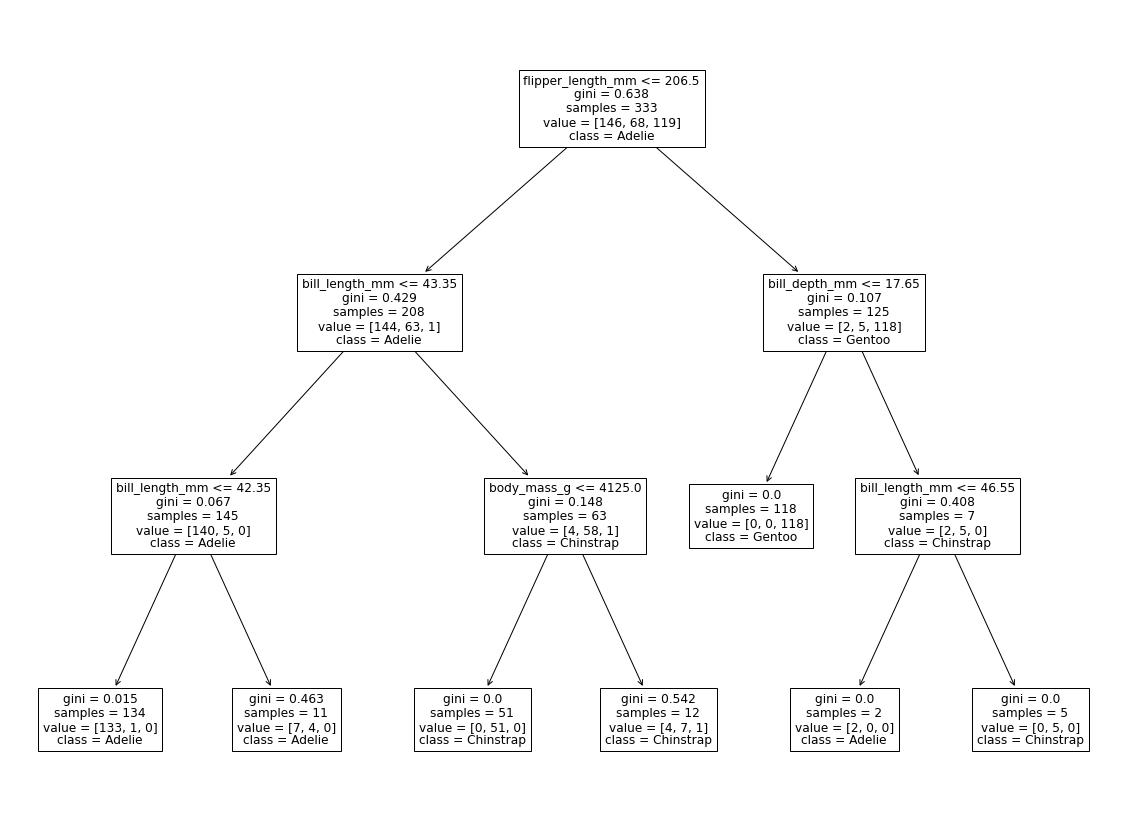

In [3]:
decision_tree = train_dec_tree_penguin(df_penguin, max_depth=3, plot=True)

In [4]:
# Classify the following penguin by manually following their path through the tree:
"""
body_mass_g = 4000
flipper_length_mm = 200
bill_depth_mm = 17
bill_length_mm = 45m
"""
class_of_penguin = 'Chinstrap'

In [5]:
# confusion matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np

# initalized kfold
skfold = StratifiedKFold(n_splits=5)

# initalized decision tree
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=3)

# default x_feat_list
x_feat_list = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# extract data from dataframe
x = df_penguin.loc[:, x_feat_list].values
y = df_penguin.loc[:, 'species'].values

# initalized y_pred
y_pred = np.empty_like(y)

for train_idx, test_idx in skfold.split(x,y):
    # training data
    x_train = x[train_idx,:]
    y_train = y[train_idx]
    
    # testing data
    x_test = x[test_idx]
    
    # fit data
    dec_tree_clf = dec_tree_clf.fit(x_train, y_train)
    
    # estiamte on test data
    y_pred[test_idx] = dec_tree_clf.predict(x_test)

Text(0.5, 0.98, 'max_depth=3 decision tree')

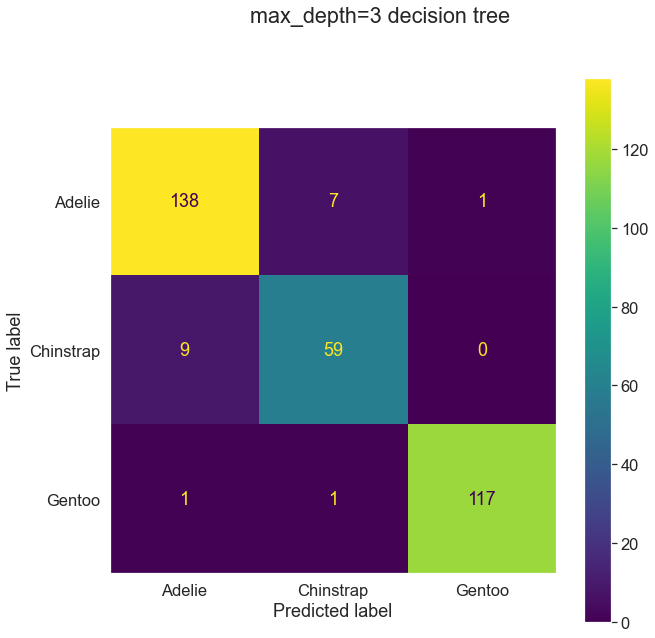

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
conf_mat_display = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y))

sns.set(font_scale=1.5)
conf_mat_display.plot()
plt.gcf().set_size_inches(10,10)
plt.grid(False)
plt.suptitle('max_depth=3 decision tree')

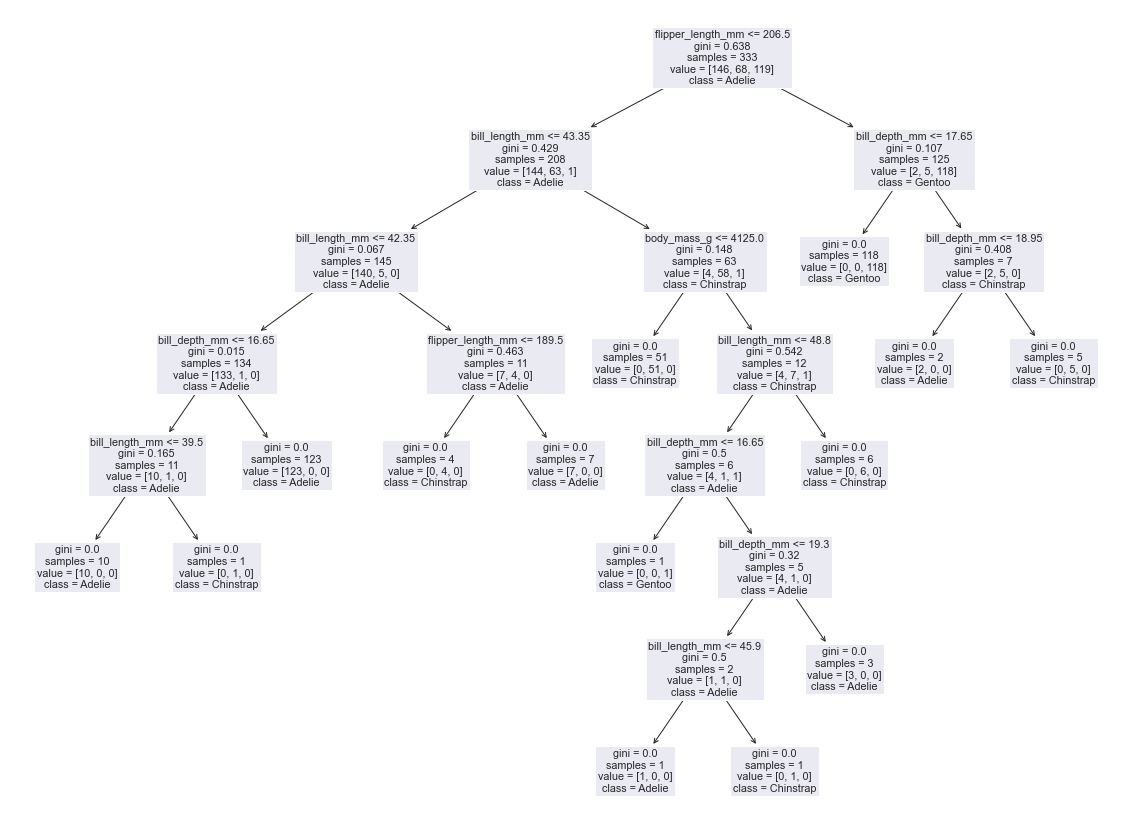

In [7]:
#repeat
from matplotlib.backends.backend_pdf import PdfPages

f_out = 'penguin_dec_tree_overfit.pdf'
n_decision_tree = train_dec_tree_penguin(df_penguin, max_depth=None, plot=True)

with PdfPages(f_out) as pdf:
    pdf.savefig(plt.gcf())

## In Class Assignment 2

1. Build a Random Forest Classifier which classifies whether a breast image contains a malignant (growing) or benign (static) tumor.
1. Print a confusion matrix which estimates how well the classifier performs on new breast images.  Qualitatively describe if your classifier is a useful clinical tool to a non-technical expert.
    - If we're estimating performance on new samples we must cross validate
1. Print a bar plot (`plot_feat_import()`) to describe which features are most useful for classification.  Qualitatively describe if these most important features are clinically meaningful.  In other words:
    - If the classifier performs well, we care about which features helped it work
    - If the classifier doesn't perform well, we don't care which features helped it "work"

In [8]:
from sklearn.datasets import load_breast_cancer

bcancer_dict = load_breast_cancer()

print(bcancer_dict['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [9]:
# loading data from sklearn is convenient because its already an array!
x = bcancer_dict['data']
y = bcancer_dict['target']

x_feat_list = bcancer_dict['feature_names']
y_feat_list = bcancer_dict['target_names']
x_feat_list

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [10]:
y_feat_list

array(['malignant', 'benign'], dtype='<U9')

In [11]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
import numpy as np

In [12]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')

Text(0.5, 0.98, 'Important features')

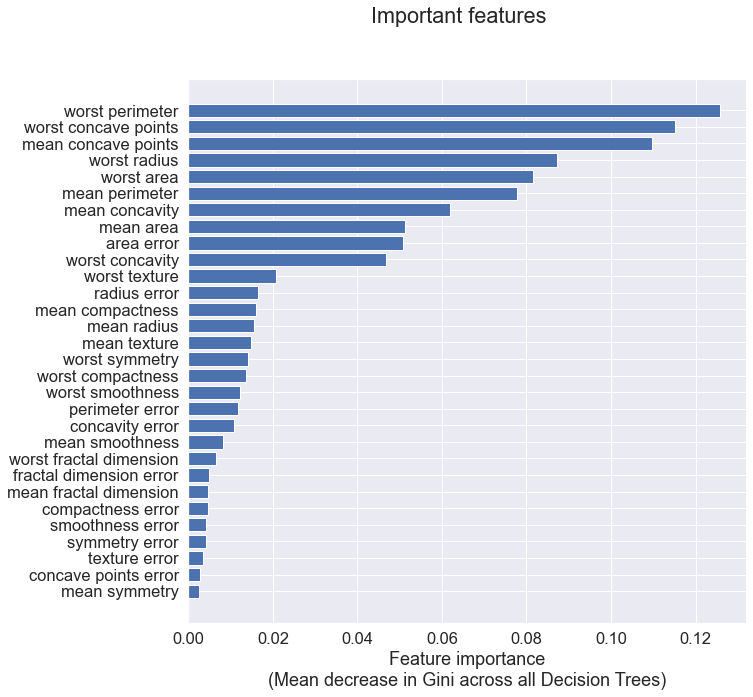

In [13]:
# random forest classifer
sns.set(font_scale=1.5)

# number of decision trees in the forest
n_estimators = 100
rf_clf = RandomForestClassifier(n_estimators=n_estimators)

# fit random forest
rf_clf.fit(x,y)

# print bar plot
plot_feat_import(x_feat_list, rf_clf.feature_importances_);
plt.gcf().set_size_inches(10,10)
plt.suptitle('Important features')


Text(0.5, 0.98, 'max_depth=3 decision tree')

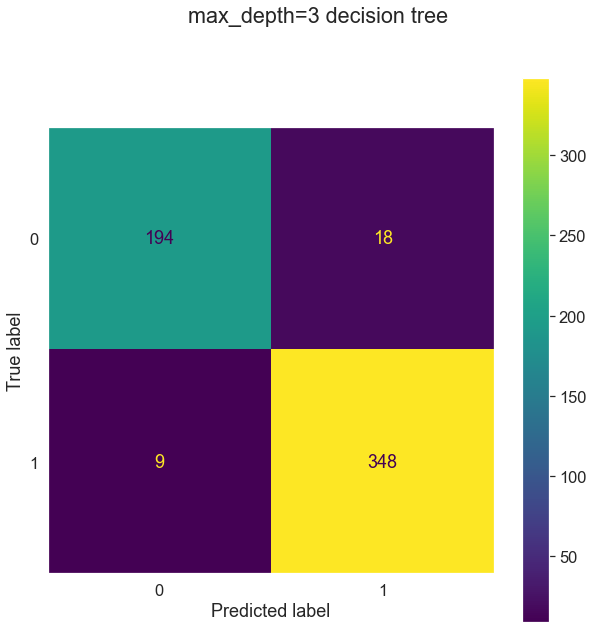

In [14]:
# confusion matrix
# initalized kfold
skfold = StratifiedKFold(n_splits=10)

# initalized random decision tree
dec_tree_clf = RandomForestClassifier(max_depth=3)

# initalized y_pred
y_pred = np.empty_like(y)

for train_idx, test_idx in skfold.split(x,y):
    # training data
    x_train = x[train_idx,:]
    y_train = y[train_idx]
    
    # testing data
    x_test = x[test_idx]
    
    # fit data
    dec_tree_clf = dec_tree_clf.fit(x_train, y_train)
    
    # estiamte on test data
    y_pred[test_idx] = dec_tree_clf.predict(x_test)

# build & plot
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
conf_mat_display = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y))

sns.set(font_scale=1.5)
conf_mat_display.plot()
plt.gcf().set_size_inches(10,10)
plt.grid(False)
plt.suptitle('max_depth=3 decision tree')

The above matrix is a useful classifer tool because out of 203, 194 predicted 0 are true and 348/366 predicted 1 are true. There is a 95% accuracy rate (roughly), which is really high accuracy rate.

The most important features that are clinically meaningful. Mean concave point (0.17), Worst perimeter (0.13), and worst concave point (03) are the top three most important features. These features are very impactful because they affected the examination for malignant or beigned tumor. 